In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
from matplotlib import pyplot as plt
import koala.phase_space as ps
from koala.example_graphs import *
import koala.plotting as pl
from koala.graph_color import color_lattice
from matplotlib import cm
from koala.flux_finder import fluxes_from_bonds,fluxes_to_labels
from numpy import linalg as la
from koala.hamiltonian import generate_majorana_hamiltonian

## Here we look at a bunch of finite size effects and try figure out where they come from
### 1: Do system-wide loops actually change the energy?

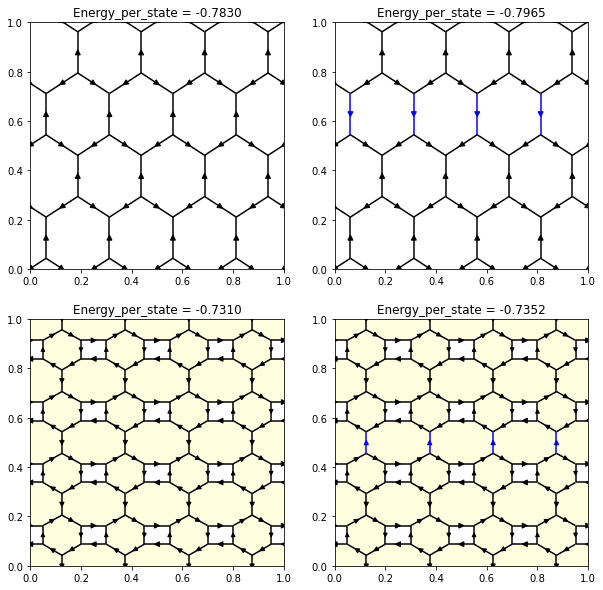

In [159]:
# first we test a few bulk, non-phase spacey system

# parameters
J_vals = np.array([1,1,1])
system_size = 4

# define the lattices
h_comb = generate_honeycomb(system_size)
hex_sq = generate_hex_square_oct(system_size)
lattices = [
    h_comb,
    h_comb,
    hex_sq,
    hex_sq,
]
comb_color = color_lattice(h_comb)
hex_sq_color = color_lattice(hex_sq)
colorings = [
    comb_color,
    comb_color,
    hex_sq_color,
    hex_sq_color
]

# pick the spins to flip
flip_values = [
    [],
    [12,15,18,21],
    [],
    [132,133,134,135],
]

# set ujk
ujk_values = [np.full(lat.n_edges , 1) for lat in lattices]

for a in range(len(ujk_values)):   
    ujk_values[a][flip_values[a]] = -1


# find energies
energies = []
for n, lattice in enumerate(lattices):
    H =  generate_majorana_hamiltonian(lattice,colorings[n], ujk_values[n],J_vals)
    energy_vals = la.eigvalsh(H)
    ground_energy = np.sum(energy_vals*(energy_vals<0))
    normalisation = len(energy_vals)/2
    energies.append(ground_energy/normalisation)

# plot lattices
fig, ax = plt.subplots(2,2,figsize = (10,10))
ax = ax.flatten()

for n, lattice in enumerate(lattices):
    pl.plot_edges(lattice, ax = ax[n],directions = ujk_values[n], labels = ujk_values[n], color_scheme = ['k', 'k', 'blue'] )
    # pl.plot_vertex_indices(lattice, ax= ax[n])
    # pl.plot_edge_indices(lattice, ax= ax[n])
    fluxes = fluxes_from_bonds(lattice,ujk_values[n])
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes), color_scheme=['white','lightyellow'], ax = ax[n])
    ax[n].set_title(f'Energy_per_state = {energies[n]:.4f}')




So it looks like adding a system-wide loop does affect things! However now let us use the phase space tricks to sample over the whole brillouin zone!

[-0.7872986013755109, -0.7872986013755101, -0.7380620541919491, -0.7380620541919497]


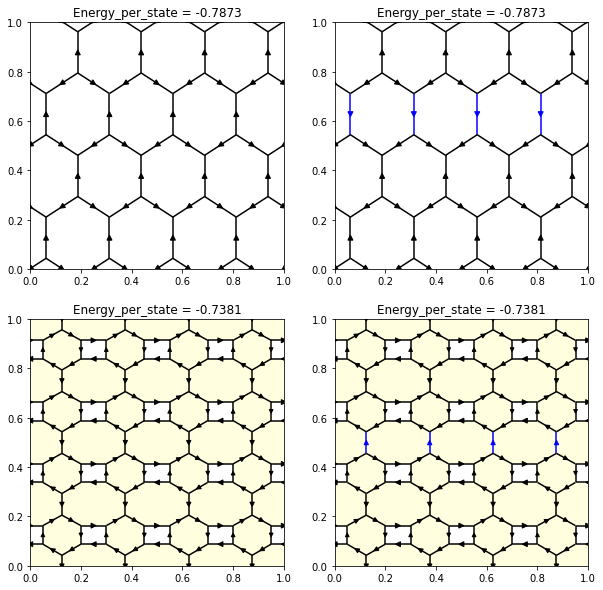

In [160]:
# phase space bastardry begins:

# use the lattices from before but now as unit cells:
k_sampling_number = 50
k_values = np.arange(k_sampling_number)*2*np.pi/k_sampling_number
KX,KY = np.meshgrid(k_values,k_values)
kx = KX.flatten()
ky = KY.flatten()
n_k_states = len(kx)


# find the energy by sampling over the wider k space
k_hamiltonians = [ps.k_hamiltonian_generator(lattices[n], colorings[n], ujk_values[n], J_vals) for n in range(len(lattices))]

energies = []
for H in k_hamiltonians:
    
    energy = 0
    for k in zip(kx,ky):
        es = la.eigvalsh(H(k))
        gs_energy = np.sum(es*(es<0))
        normalisation = len(es)/2
        energy += gs_energy/normalisation
    energies.append(energy/n_k_states)
print(energies)

# plot lattices
fig, ax = plt.subplots(2,2,figsize = (10,10))
ax = ax.flatten()

for n, lattice in enumerate(lattices):
    pl.plot_edges(lattice, ax = ax[n],directions = ujk_values[n], labels = ujk_values[n], color_scheme = ['k', 'k', 'blue'] )
    # pl.plot_vertex_indices(lattice, ax= ax[n])
    # pl.plot_edge_indices(lattice, ax= ax[n])
    fluxes = fluxes_from_bonds(lattice,ujk_values[n])
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes), color_scheme=['white','lightyellow'], ax = ax[n])
    ax[n].set_title(f'Energy_per_state = {energies[n]:.4f}')

You can see here that, once we average over more points in the brillouin zone by twisting the boundaries, the effect of the system wide spin flips vanishes. The explanation is that adding a system wide spin flip does not actually change the physics - it just adds a -1 to a line crossing the system - equivalent to adding an e^(i pi) phase to the boundary. This shifts the brillouin zone over and the effect is that we end up sampling 5 different points from a slightly different part of the phase space, getting a slightly different value of the energy!

### We can show this by looking at the gap size over phase space:


In [161]:

k_vals = np.concatenate([KX[:,:,np.newaxis],KY[:,:,np.newaxis]],axis=2)

gaps = []
for H in k_hamiltonians:
    def find_gap(k):
        h = H(k)
        vals = la.eigvalsh(h)
        return np.min(np.abs(vals))

    gaps.append(np.apply_along_axis(find_gap,2,k_vals))


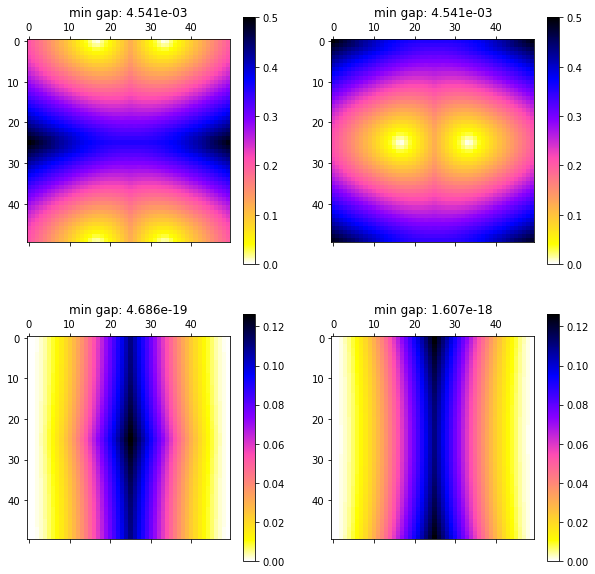

In [162]:


fig, axes = plt.subplots(2,2,figsize = (10,10))
for n, ax in enumerate(axes.flatten()):

    cax = ax.matshow(gaps[n], cmap = 'gnuplot2_r',vmin = 0)
    plt.colorbar(cax,ax=ax)
    ax.set_title(f'min gap: {np.min(gaps[n]):.3e}')